# Создание и обучение детектора фейковых новостей на Python

В этой работе используется [__набор данных__](https://www.kaggle.com/c/fake-news/data?ref=morioh.com&utm_source=morioh.com) о фальшивых новостях от Kaggle , чтобы классифицировать ненадежные новостные статьи как фальшивые новости.  
Есть полный набор обучающих данных, содержащий следующие характеристики:

__id__: уникальный идентификатор новостной статьи  
__title__: название новостной статьи  
__author__: автор новостной статьи  
__text__: текст статьи  
__label__: метка, помечающая статью как потенциально ненадежную и обозначаемая цифрой 1 (ненадежная или поддельная) или 0 (надежная).  

Это проблема бинарной классификации, в которой необходимо предсказать, является ли конкретная новость достоверной или нет.  

### Установка необходиных зависимостей

In [16]:
pip install transformers nltk pandas numpy matplotlib seaborn wordcloud

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [30]:
# Импорт и загрузка необходимых пакетов

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [31]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Загрузка файла с данными для обучения
news_d = pd.read_csv("data/train.csv")

In [23]:
# Вывод формы,названий столбцов и первых строк новостных данных
print("Форма новостных данных:", news_d.shape)
print("Столбцы новостных данных:", news_d.columns)
news_d.head()

Форма новостных данных: (101, 5)
Столбцы новостных данных: Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [24]:
# Статистика по текстам статей: минимум, среднее, максимум и межквартильный диапазон

txt_length = news_d.text.str.split().str.len()
txt_length.describe()

# Статистика по заголовкам

title_length = news_d.title.str.split().str.len()
title_length.describe()

count    100.000000
mean      12.470000
std        3.872866
min        1.000000
25%       10.000000
50%       13.000000
75%       15.000000
max       23.000000
Name: title, dtype: float64

### Распределение классов  

Графики подсчета для обеих меток:

1: Ненадежные
0: Надежные
Распределение меток:
0    55
1    46
Name: label, dtype: int64


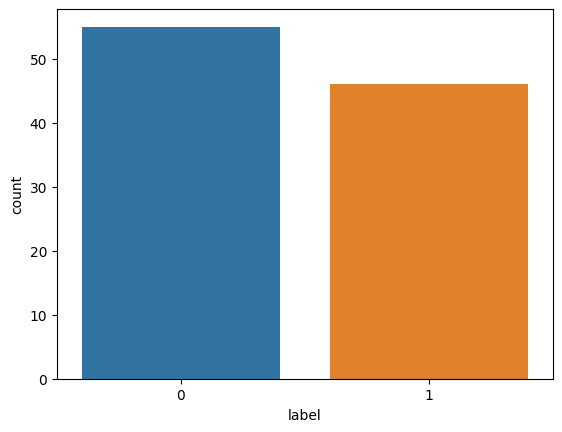

In [26]:
sns.countplot(x="label", data=news_d);
print("1: Ненадежные")
print("0: Надежные")
print("Распределение меток:")
print(news_d.label.value_counts());

In [27]:
print(round(news_d.label.value_counts(normalize=True),2)*100);

0    54.0
1    46.0
Name: label, dtype: float64


Далее, очистим набор данных, чтобы провести некоторый анализ:

+ Удаление неиспользуемых строк и столбцов.  
+ Перезаписать нулевые значения на None  
+ Очистить текст от неиспользуемых символов
+ Удаление специальных символов.
+ Удаление стоп-слов.  

In [28]:
column_n = ['id', 'title', 'author', 'text', 'label']
remove_c = ['id','author']
categorical_features = []
target_col = ['label']
text_f = ['title', 'text']

In [29]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

In [32]:
ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [34]:
# Удалить неиспользуемые столбцы
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Перезаписать нулевые значения на None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    df = remove_unused_c(df)
    df = null_process(df)
    return df

# Очистка текста от неиспользуемых символов
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')
    text = str(text).replace(r'[^\.\w\s]', ' ')
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip() 
    return text

# Удаление стоп-слов
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

In [36]:

df = clean_dataset(news_d)
df["text"] = df.text.apply(nltk_preprocess)
df["title"] = df.title.apply(nltk_preprocess)
df.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


Выполним два анализа данных.

__Одномерный анализ__: это статистический анализ текста. Используем облако слов для этой цели.  
Облако слов — это подход к визуализации текстовых данных, при котором наиболее распространенный термин представлен шрифтом самого крупного размера.  

__Двумерный анализ__: здесь будут использоваться биграммы и триграммы.  
Согласно Википедии: _« n-грамма представляет собой непрерывную последовательность n элементов из заданного образца текста или речи.  
Согласно приложению, элементы могут быть фонемами, слогами, буквами, словами или парами оснований. обычно собираются из текстового или речевого корпуса»_.


### Облако одного слова  

Наиболее часто встречающиеся слова выделены жирным и крупным шрифтом в облаке слов.

Будут использоваться функции из библиотеки WordCloudwordcloud() и generate().

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

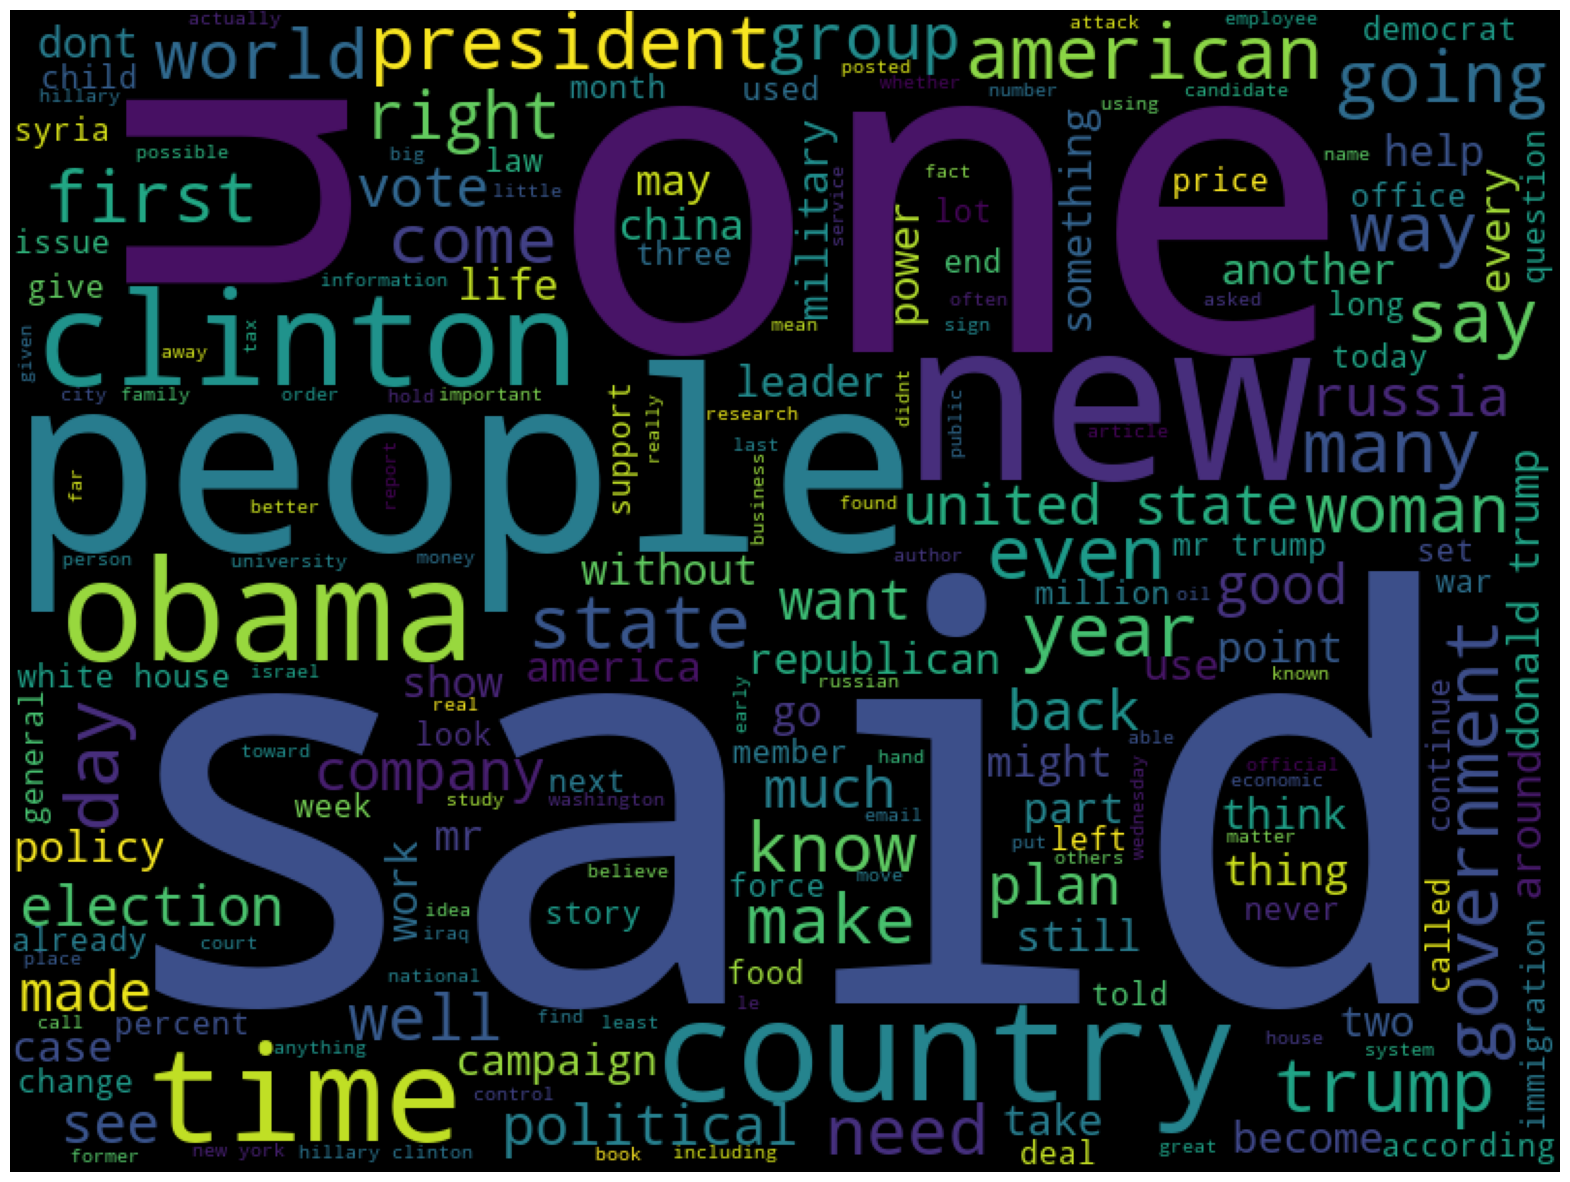

In [18]:
# Инициализировать облако слов
wordcloud = WordCloud( background_color='black', width=800, height=600)
# Сгенерировать облако слов
text_cloud = wordcloud.generate(' '.join(df['text']))
# Построение облака слов
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [9]:
# Достоверные новостей

true_n = ' '.join(df[df['label']==0]['text']) 
wc = wordcloud.generate(true_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

NameError: name 'df' is not defined

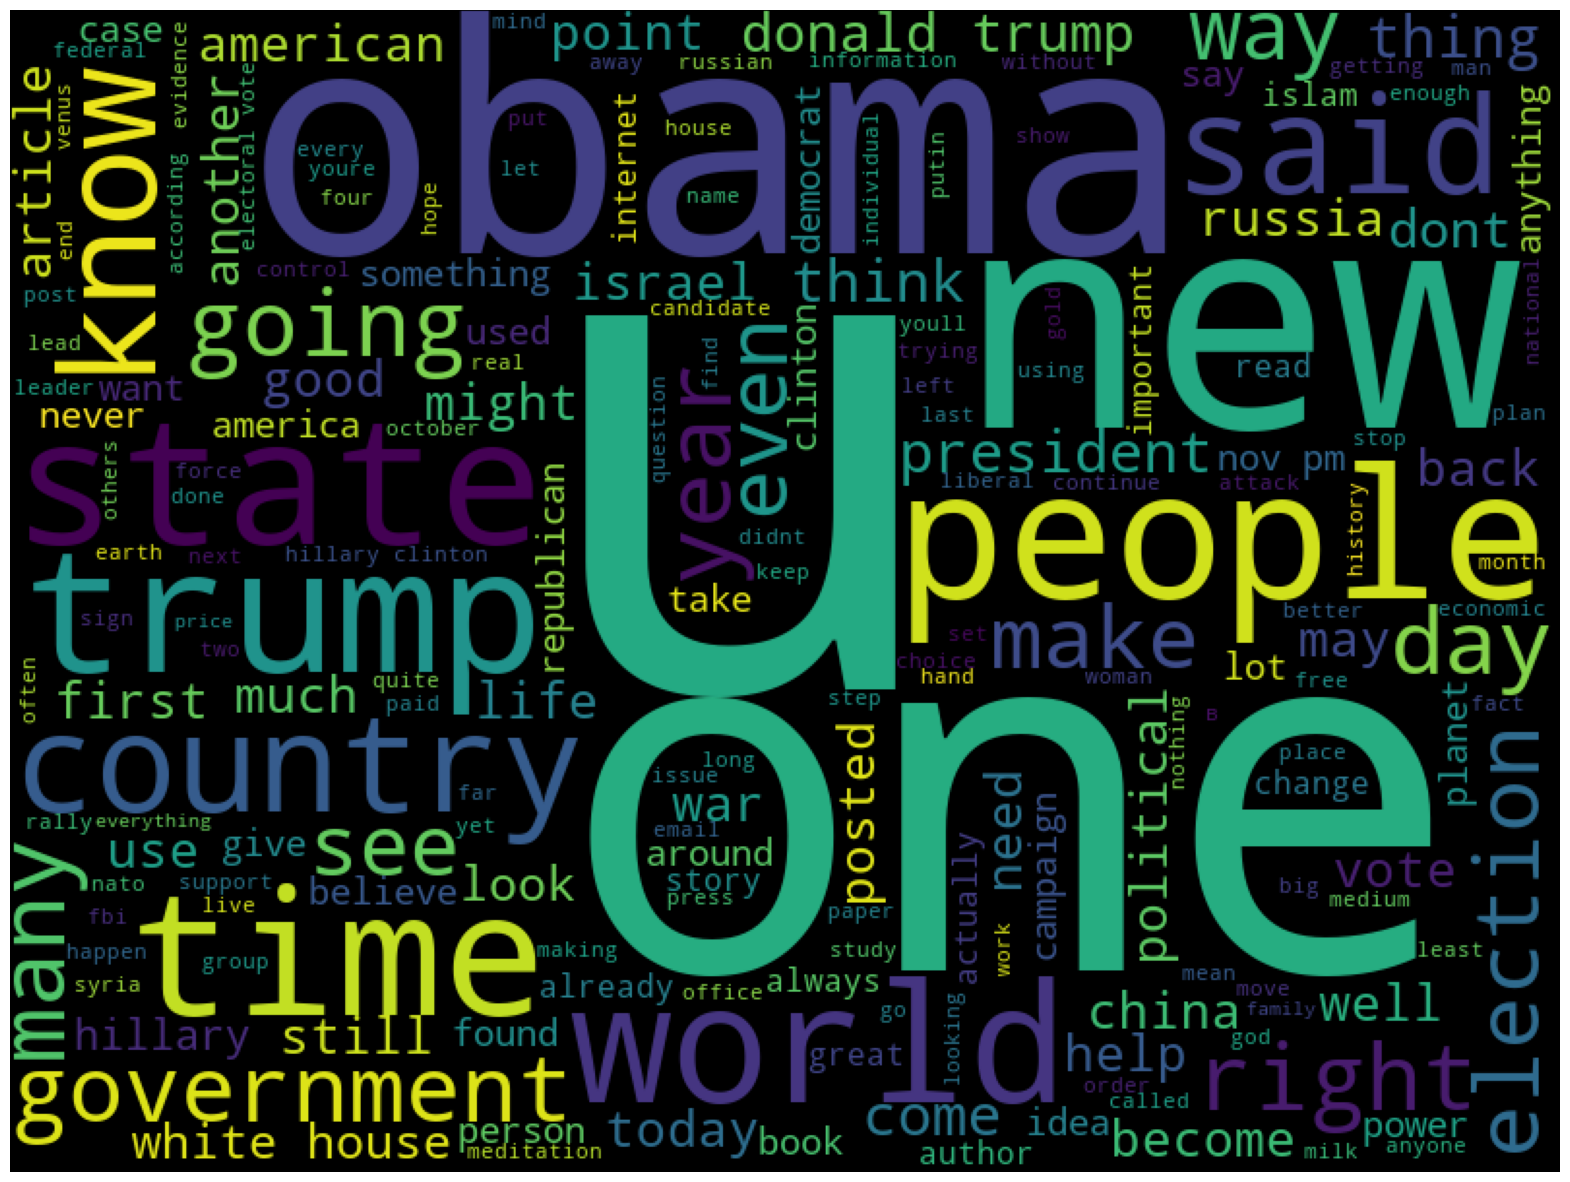

In [20]:
# Фейковые новости

fake_n = ' '.join(df[df['label']==1]['text'])
wc= wordcloud.generate(fake_n)
plt.figure(figsize=(20,30))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Самая частая биграмма (комбинация из двух слов)  

N-грамма — это последовательность букв или слов. Униграмма символов состоит из одного символа, а биграмма состоит из последовательности из двух символов.  
Точно так же словесные N-граммы состоят из последовательности n слов. 

In [21]:
def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurences", n=2):
  """Utility function to plot top n-grams"""
  true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
  true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

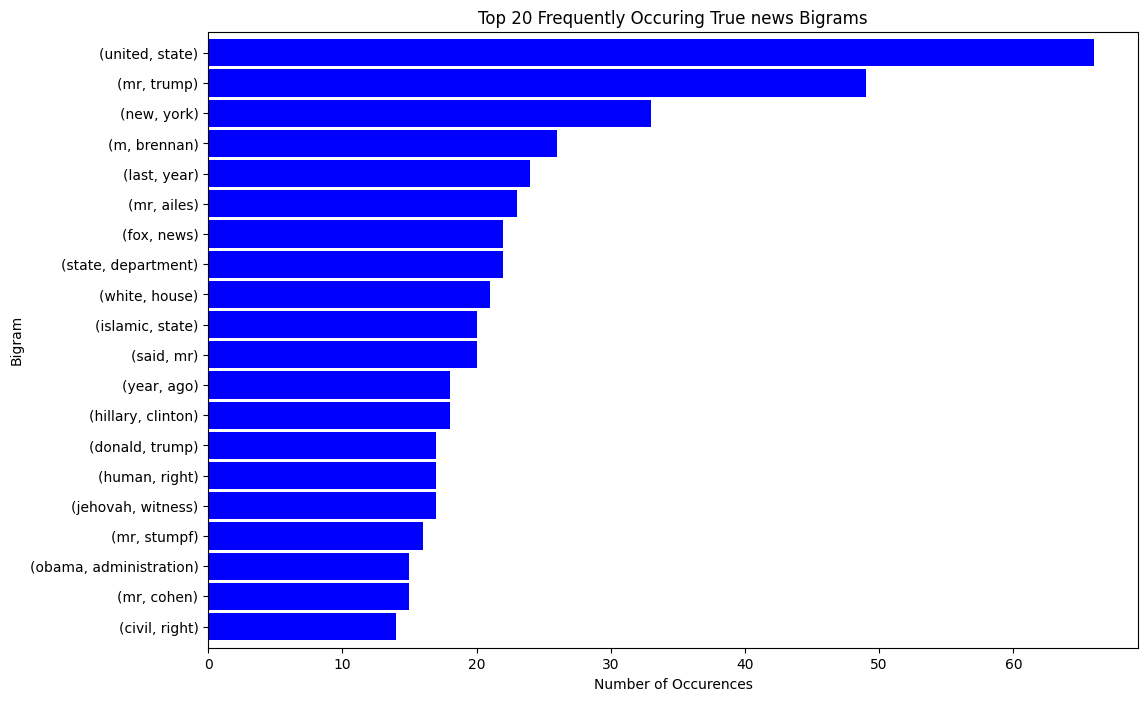

In [22]:
# Достоверные новостей

plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)

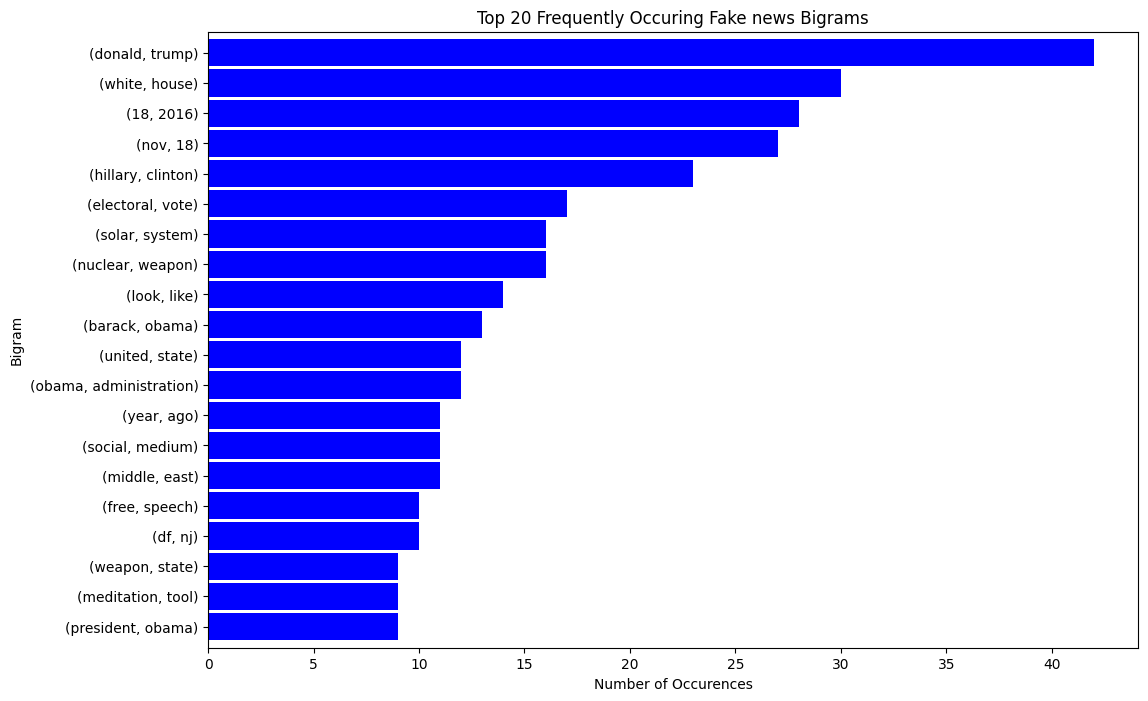

In [29]:
# Фейковые новости

plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

### Самая частая триграмма (комбинация из трех слов)

Самая распространенная триграмма на достоверных новостях:

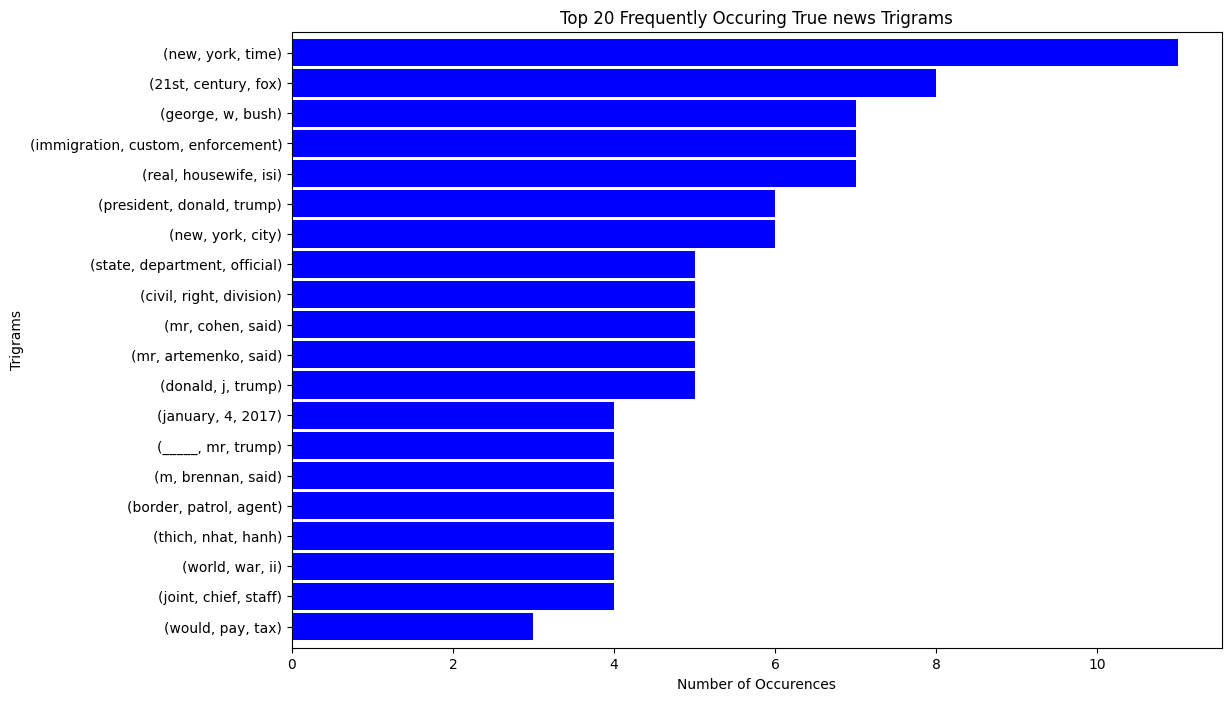

In [23]:
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Trigrams', "Trigrams", n=3)

Для фейковых новостей:

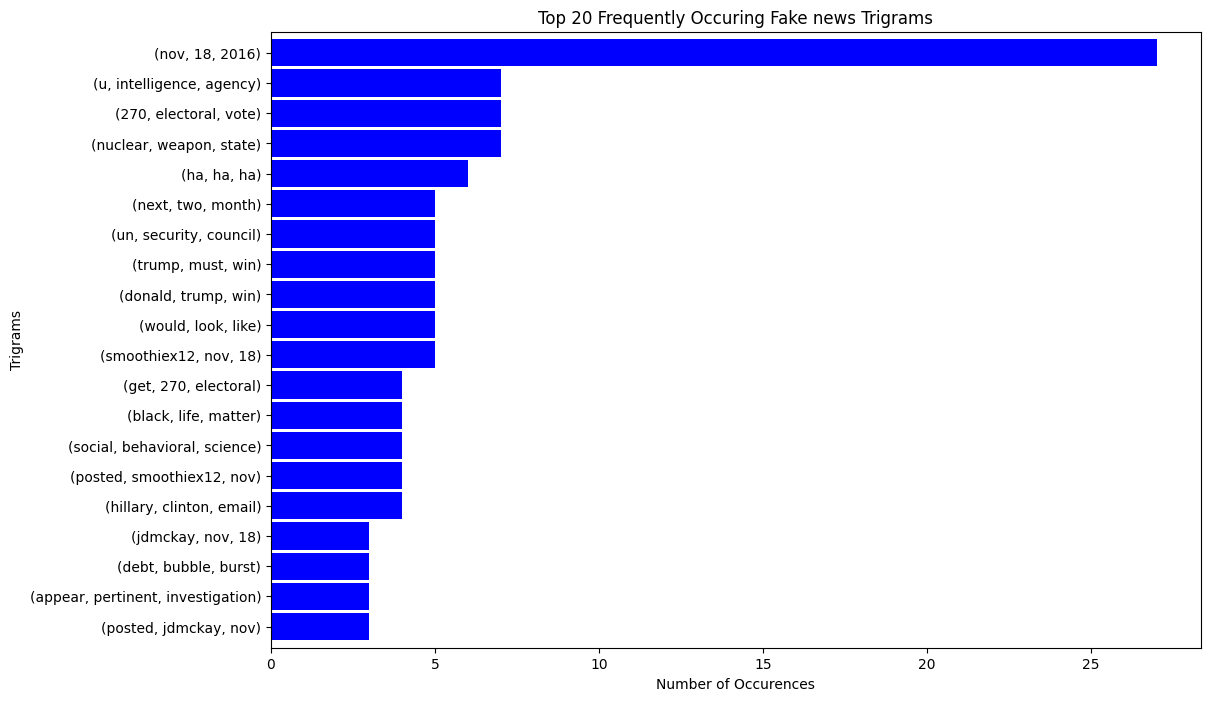

In [24]:
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Trigrams', "Trigrams", n=3)

## Создание классификатора путем тонкой настройки BERT

In [40]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split
import random

Используемая модель: [__bert-base-uncased__](https://huggingface.co/models?filter=text-classification)

In [2]:
model_name = "bert-base-uncased"
# максимальная длина последовательности для каждого документа/предложения
max_length = 512

In [3]:
# загрузка токенизатор
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

### Подготовка данных  

Очистка NaN значения из text, author и title столбцов:

In [41]:
news_df = news_d[news_d['text'].notna()]
news_df = news_df[news_df["author"].notna()]
news_df = news_df[news_df["title"].notna()]

Создадим функцию, которая принимает набор данных в качестве фрейма данных Pandas и возвращает разделение текстов и меток для обучения/проверки в виде списков:

In [46]:
def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []
  for i in range(len(df)):
    text = df["text"].iloc[i]
    label = df["label"].iloc[i]
    if include_title:
      text = df["title"].iloc[i] + " - " + text
    if include_author:
      text = df["author"].iloc[i] + " : " + text
    if text and label in [0, 1]:
      texts.append(text)
      labels.append(label)
  return train_test_split(texts, labels, test_size=test_size)

In [47]:
train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

Приведенная выше функция принимает набор данных в виде фрейма данных и возвращает их в виде списков, разделенных на наборы для обучения и проверки.  
Значение include_title означает True, что мы добавляем title столбец в столбец, который text будем использовать для обучения, а значение include_authorозначает , True что мы также добавляем authorего в текст.

Проверка, что метки и тексты имеют одинаковую длину:

In [48]:
print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

71 71
18 18


### Токенизация набора данных  

Используем токенизатор BERT для токенизации набора данных:

In [49]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

Преобразование кодировок в набор данных PyTorch:

In [52]:
class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

### Загрузка и тонкая настройка модели  

Будем использовать BertForSequenceClassification для загрузки модели трансформатора BERT:

In [53]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Для num_labels установили значение 2, так как это бинарная классификация.  
Ниже функция представляет собой обратный вызов для расчета точности на каждом этапе проверки:

In [54]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

Инициализируем параметры обучения:

In [55]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=5,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

Установка logging_steps и save_steps на 200, что означает, что мы собираемся выполнить оценку и сохранить веса модели на каждом шаге обучения.  

Создадим экземпляр тренера:

In [57]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [39]:
# Обучение модели
trainer.train()

C:\Users\Maksim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 71
  Num Epochs = 1
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 1
  Total optimization steps = 15
  Number of trainable parameters = 109483778
100%|██████████| 15/15 [18:41<00:00, 59.18s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 15/15 [18:41<00:00, 74.78s/it]


{'train_runtime': 1121.5355, 'train_samples_per_second': 0.063, 'train_steps_per_second': 0.013, 'train_loss': 0.6823708852132161, 'epoch': 1.0}


TrainOutput(global_step=15, training_loss=0.6823708852132161, metrics={'train_runtime': 1121.5355, 'train_samples_per_second': 0.063, 'train_steps_per_second': 0.013, 'train_loss': 0.6823708852132161, 'epoch': 1.0})

### Оценка модели  

Поскольку load_best_model_at_end установлено значение True, лучшие веса будут загружены после завершения тренировки.

In [40]:
# Оценка текущей модели после обучения
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 18
  Batch size = 20
100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


{'eval_loss': 0.7653952836990356,
 'eval_accuracy': 0.3888888888888889,
 'eval_runtime': 69.8758,
 'eval_samples_per_second': 0.258,
 'eval_steps_per_second': 0.014,
 'epoch': 1.0}

Сохранение модели и токенизатора:

In [41]:
# Сохранение модели и токенизатора
model_path = "fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in fake-news-bert-base-uncased\config.json
Model weights saved in fake-news-bert-base-uncased\pytorch_model.bin
tokenizer config file saved in fake-news-bert-base-uncased\tokenizer_config.json
Special tokens file saved in fake-news-bert-base-uncased\special_tokens_map.json


('fake-news-bert-base-uncased\\tokenizer_config.json',
 'fake-news-bert-base-uncased\\special_tokens_map.json',
 'fake-news-bert-base-uncased\\vocab.txt',
 'fake-news-bert-base-uncased\\added_tokens.json',
 'fake-news-bert-base-uncased\\tokenizer.json')

Новая папка, содержащая конфигурацию модели и веса, появится после запуска указанной выше ячейки.  
Если нужно выполнить прогнозирование, просто используете from_pretrained() метод, который использовался при загрузке модели.  

Создадим функцию, которая принимает в качестве аргумента текст статьи и возвращает, фейк это или нет:

In [59]:
def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "Надежный",
        1: "Фейк"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())


### Проверка работы обученного детектора   

Возьмем первую новость из test.csv и проверим ее

In [61]:
real_news = """
Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times",Daniel Victor,"If at first you don’t succeed, try a different sport. Tim Tebow, who was a Heisman   quarterback at the University of Florida but was unable to hold an N. F. L. job, is pursuing a career in Major League Baseball. <SNIPPED>
"""

In [62]:
get_prediction(real_news, convert_to_label=True)

'Фейк'

## Набор тестовых данных и данных для обучения  

[Fake News](https://www.kaggle.com/c/fake-news/data?ref=morioh.com&utm_source=morioh.com)

## Используемые источники

1. [Detecting Fake News with Python and Machine Learning](https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/)
2. [Как создать детектор фейковых новостей на Python](https://morioh.com/p/4c8e3f0bf2e1)